# LPNet concept


## Imports

In [5]:
from PIL import Image
import os
import torch
from torch import nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} DEVICE")

Using cuda DEVICE


## Loading images

In [7]:
%time
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            images.append(img)
    return images

folder_path = f"/kaggle/input/sd7k-test-input"
loaded_images = load_images_from_folder(folder_path)[:25]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [8]:
print(len(loaded_images))
print(type(loaded_images[0]))
print(loaded_images[0].size)

25
<class 'PIL.PngImagePlugin.PngImageFile'>
(2452, 3694)


In [9]:
transform = transforms.Compose([
    transforms.Resize((768,1024)),
    transforms.ToTensor(),           # Convert images to tensors
])

In [10]:
# Convert PIL images to tensors
%time
tensor_images = [transform(img) for img in loaded_images]
tensor_images = torch.stack(tensor_images)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [11]:
if DEVICE == 'cuda':
    tensor_images = tensor_images.to(DEVICE)

In [12]:
print(len(tensor_images))
print(type(tensor_images[0]))
print(tensor_images[0].shape)

25
<class 'torch.Tensor'>
torch.Size([3, 768, 1024])


## Network

In [13]:
class LPNet(nn.Module):
    def __init__(self, L=2, interp_mode='nearest-exact',lr=0.1):
        super(LPNet,self).__init__()

        self.L = L
        self.interp_mode = interp_mode
        self.final_input_dim = None

        self.resid_refinement_net = nn.Sequential(
            # Depth-sequential network
            nn.Conv2d(in_channels=9, out_channels=32, kernel_size=1),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
            nn.LeakyReLU(),

#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, groups=64),
#             nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),
#             nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
        )

        self.next_res_net = nn.ModuleList()
        for l in range(L-1):
            layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=1),
                nn.LeakyReLU(),

                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1),
                nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1),
            )

            self.next_res_net.append(layers)

        self.loss_layer = nn.L1Loss()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self,I0):

        '''
            Downsampling the original image
        '''
        H = []
        shapes = []
        IL = I0
        for l in range(self.L):
            curr_dim = IL.shape
            shapes.append(curr_dim)

            IL_next = nn.functional.interpolate(IL,size=[curr_dim[2]//2,curr_dim[3]//2],mode=self.interp_mode)
            IL_next_up = nn.functional.interpolate(IL_next,size=[curr_dim[2],curr_dim[3]],mode=self.interp_mode)
            Hl = IL - IL_next_up
            H.append(Hl)

            IL = IL_next
        
        self.final_input_dim = IL[0].shape
        # return IL, H

        # '''
        #     I2IT: inversion
        # '''
        # IL_cap = []
        # for i in range(I0.shape[0]):
        #     IL_cap.append(transforms.functional.invert(IL[i]))
        # IL_cap = torch.stack(IL_cap)
        '''
            I2IT: nothing
        '''
        IL_cap = IL
    
        '''
            Upsampling the translated image
        '''
#         if(raw_up==True):
#             Il_cap = IL_cap
#             for l in range(self.L-1,-1,-1):
#                 Il_cap_next_up = nn.functional.interpolate(Il_cap,size=[shapes[l][2],shapes[l][3]],mode=self.interp_mode)
#                 Il_cap = H[l] + Il_cap_next_up

#             return Il_cap
        
        IL_up = nn.functional.interpolate(IL,size=[shapes[self.L-1][2],shapes[self.L-1][3]],mode=self.interp_mode)
        IL_cap_up = nn.functional.interpolate(IL_cap,size=[shapes[self.L-1][2],shapes[self.L-1][3]],mode=self.interp_mode)
        ResNet_inp = torch.cat([IL_up, IL_cap_up, H[self.L-1]],dim=1)
        
        # Ml_next = torch.mean(torch.stack([IL_up, IL_cap_up, H[self.L-1]]),dim=0,keepdim=True)[0]
        Ml_next = self.resid_refinement_net(ResNet_inp)
        
        H_ref = H[self.L-1]*Ml_next
        Il_cap = H_ref + IL_cap_up
#         print(H_ref.shape,H[self.L-1].shape,Ml_next.shape)

        for l in range(self.L-2,-1,-1):
            Ml_next_up = nn.functional.interpolate(Ml_next,size=[shapes[l][2],shapes[l][3]],mode=self.interp_mode)
            Ml_next = self.next_res_net[l](Ml_next_up)
            
            Il_cap_up = nn.functional.interpolate(Il_cap,size=[shapes[l][2],shapes[l][3]],mode=self.interp_mode)
        
            H_ref = H[l]*Ml_next
            Il_cap = H_ref + Il_cap_up

        return Il_cap
    
    def loss(self,I0, I0_cap,):
        with  torch.no_grad():
            I0_cap_pred = self(I0)

            loss = self.loss_layer(I0_cap_pred, I0_cap)

            return loss.item()
        
    def translate(self,I0):
        with  torch.no_grad():
            return self(I0)

    def fit(self, I0, I0_cap, epochs=10):
       
        for epoch in tqdm(range(epochs)):
            I0_cap_pred = self(I0)

            loss = self.loss_layer(I0_cap_pred, I0_cap)
            if epoch == 0 or epoch == epochs//2 or epoch == epochs-1:
                print(f'{epoch+1}\t {loss.item()}')

            self.optimizer.zero_grad()

            loss.backward()
            
            self.optimizer.step()

        return self.loss(I0, I0_cap)       

            

In [14]:
lp_model = LPNet(L=2)
# print(sum(p.numel() for p in lp_model.parameters()))
if DEVICE == 'cuda':
    lp_model = lp_model.to(DEVICE)

In [15]:
%time
lp_model.fit(tensor_images,tensor_images, epochs = 100)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


  0%|          | 0/100 [00:00<?, ?it/s]

1	 0.035271696746349335


 51%|█████     | 51/100 [00:19<01:14,  1.52s/it]

51	 0.0015978098381310701


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]

100	 0.0003362604766152799


0.0006054743425920606

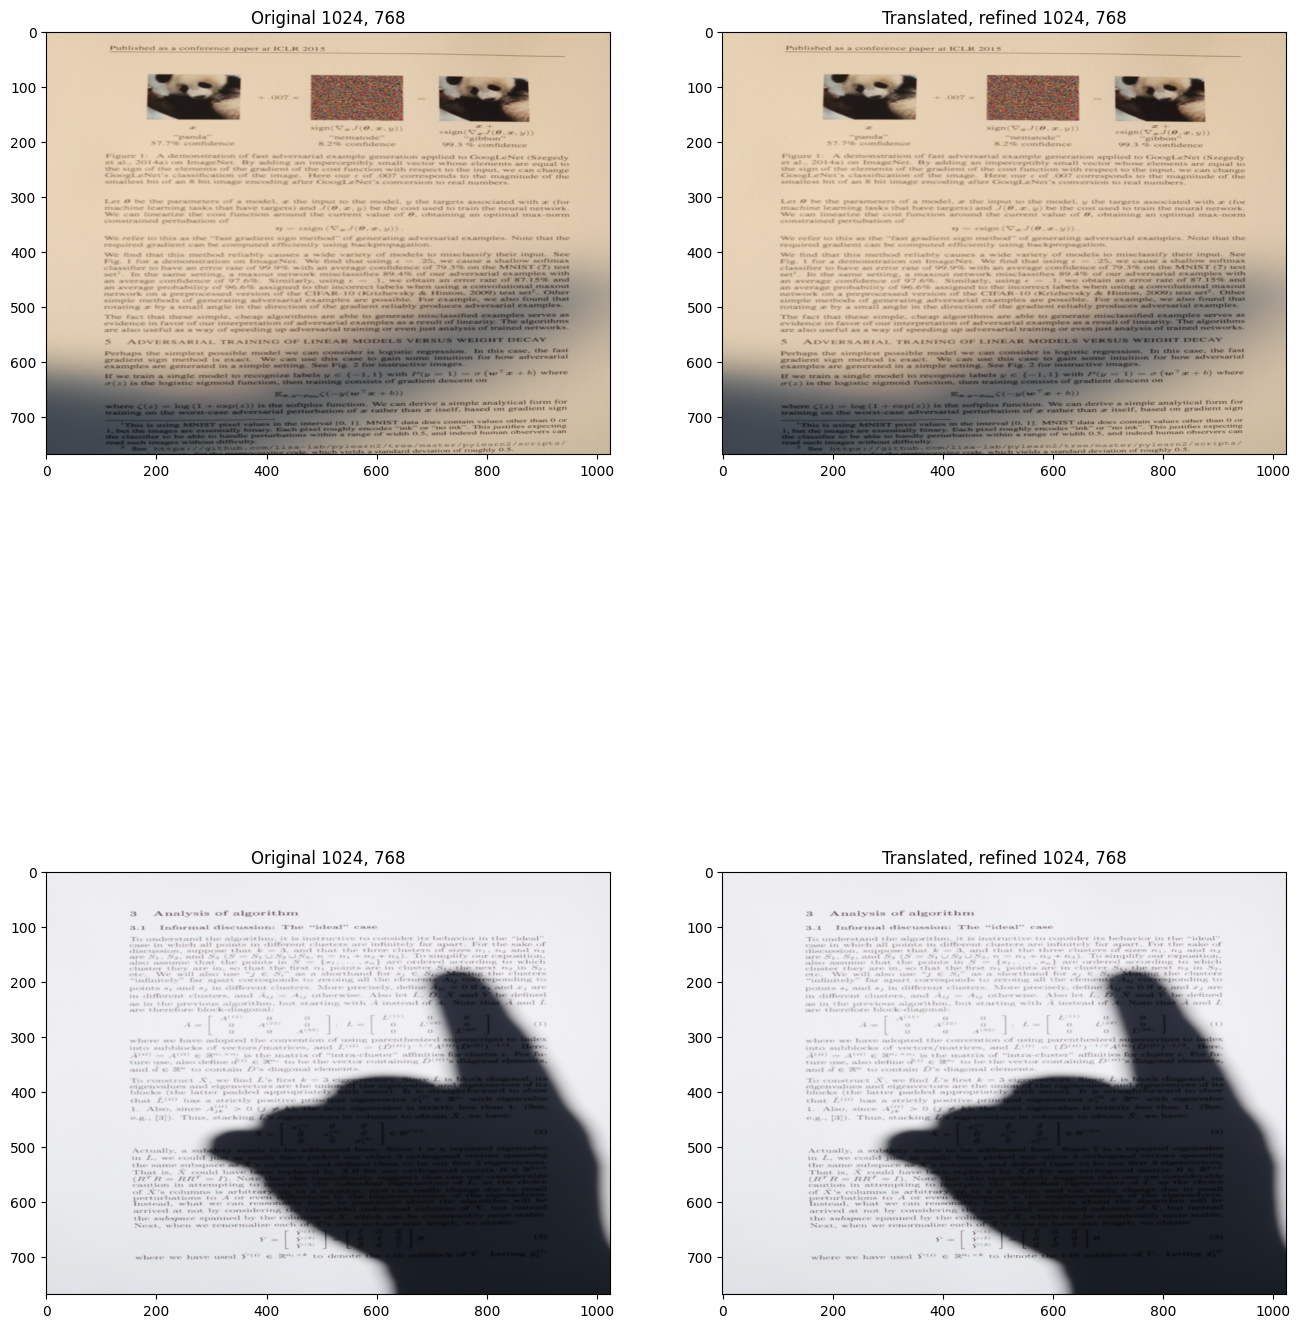

In [18]:
I0_cap = lp_model.translate(tensor_images[:2])

n_img=2
fig, axs = plt.subplots(n_img,2,figsize=(8*2, 10*n_img))

for i in range(n_img):
    axs[i][0].set_title(f'Original {tensor_images[i].shape[2]}, {tensor_images[i].shape[1]}')
    axs[i][0].imshow(np.swapaxes(np.swapaxes(tensor_images[i].cpu(),0, 2),0,1))
    
    axs[i][1].set_title(f'Translated, refined {I0_cap[i].shape[2]}, {I0_cap[i].shape[1]}')
    axs[i][1].imshow(np.swapaxes(np.swapaxes(I0_cap[i].cpu().detach().numpy(),0, 2),0,1))